<a href="https://colab.research.google.com/github/lokeshpara/Deeplearning/blob/S10/EVA_session10_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/EVA/S10/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/EVA/S10


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
import numpy as np
import torchvision.transforms as transforms
import albumentations
from albumentations.pytorch import ToTensor
import random
from GradCAM.gradcam_visualize import GradCAMView
import dataloader10
import resnet
import train10
import test10
from lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


  pip install torch-lr-finder -v --global-option="amp"


  dog truck  frog   car


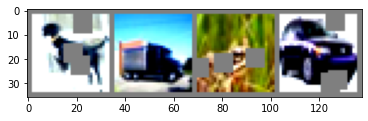

In [22]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(dataloader10.train_loader_Alb)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = resnet.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


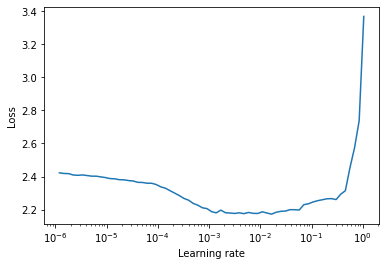

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloader10.train_loader, end_lr=100, num_iter=100, step_mode="exp")                                
lr_finder.plot() 
#lr_finder.reset()                                                                                                                                              

In [0]:
Best_lr=lr_finder.history['lr'][lr_finder.history['loss'].index(min(lr_finder.history['loss']))]

In [0]:
lr_finder.reset()

In [30]:
print("lr:" , Best_lr)
print('Loss:', lr_finder.best_loss)

lr: 0.01659586907437559
Loss: 2.17259062088096


In [31]:
model =  resnet.ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), Best_lr , momentum=0.9, weight_decay=0) 
scheduler = ReduceLROnPlateau(optimizer, patience = 3,min_lr=1e-4)
loss_func=nn.CrossEntropyLoss()

for epoch in range(50):
    print("Epoch:", epoch)
    train10.train(model, device, dataloader10.train_loader_Albumentation, optimizer, loss_func, epoch)
    # scheduler.step()
    test10.test(model, device, dataloader10.test_loader, loss_func, last_epoch=True)
    scheduler.step(test10.test_losses[-1])

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0


Epoch= 0 Loss=1.4613898992538452 Batch_id=781 Accuracy=38.02: 100%|██████████| 782/782 [00:31<00:00, 24.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 4988/10000 (49.88%)

Epoch: 1


Epoch= 1 Loss=1.1093063354492188 Batch_id=781 Accuracy=53.58: 100%|██████████| 782/782 [00:31<00:00, 24.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 5938/10000 (59.38%)

Epoch: 2


Epoch= 2 Loss=1.0328679084777832 Batch_id=781 Accuracy=61.90: 100%|██████████| 782/782 [00:31<00:00, 24.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 6404/10000 (64.04%)

Epoch: 3


Epoch= 3 Loss=0.9672787189483643 Batch_id=781 Accuracy=66.39: 100%|██████████| 782/782 [00:31<00:00, 24.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0125, Accuracy: 7252/10000 (72.52%)

Epoch: 4


Epoch= 4 Loss=0.4789879620075226 Batch_id=781 Accuracy=69.93: 100%|██████████| 782/782 [00:31<00:00, 24.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 7559/10000 (75.59%)

Epoch: 5


Epoch= 5 Loss=0.8505520820617676 Batch_id=781 Accuracy=72.59: 100%|██████████| 782/782 [00:31<00:00, 24.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 7662/10000 (76.62%)

Epoch: 6


Epoch= 6 Loss=0.38705912232398987 Batch_id=781 Accuracy=74.86: 100%|██████████| 782/782 [00:31<00:00, 24.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0104, Accuracy: 7815/10000 (78.15%)

Epoch: 7


Epoch= 7 Loss=0.5853675603866577 Batch_id=781 Accuracy=76.38: 100%|██████████| 782/782 [00:31<00:00, 24.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 8266/10000 (82.66%)

Epoch: 8


Epoch= 8 Loss=0.5517834424972534 Batch_id=781 Accuracy=77.84: 100%|██████████| 782/782 [00:31<00:00, 24.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 8312/10000 (83.12%)

Epoch: 9


Epoch= 9 Loss=0.7383806705474854 Batch_id=781 Accuracy=79.21: 100%|██████████| 782/782 [00:31<00:00, 24.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 8019/10000 (80.19%)

Epoch: 10


Epoch= 10 Loss=0.4091240465641022 Batch_id=781 Accuracy=80.00: 100%|██████████| 782/782 [00:31<00:00, 24.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 8369/10000 (83.69%)

Epoch: 11


Epoch= 11 Loss=1.6139639616012573 Batch_id=781 Accuracy=81.02: 100%|██████████| 782/782 [00:31<00:00, 24.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 8522/10000 (85.22%)

Epoch: 12


Epoch= 12 Loss=0.9859172701835632 Batch_id=781 Accuracy=81.66: 100%|██████████| 782/782 [00:31<00:00, 24.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 8552/10000 (85.52%)

Epoch: 13


Epoch= 13 Loss=0.3798350989818573 Batch_id=781 Accuracy=82.82: 100%|██████████| 782/782 [00:31<00:00, 24.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 8571/10000 (85.71%)

Epoch: 14


Epoch= 14 Loss=0.5358170866966248 Batch_id=781 Accuracy=83.41: 100%|██████████| 782/782 [00:31<00:00, 24.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8665/10000 (86.65%)

Epoch: 15


Epoch= 15 Loss=0.8923870325088501 Batch_id=781 Accuracy=84.16: 100%|██████████| 782/782 [00:31<00:00, 24.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 8507/10000 (85.07%)

Epoch: 16


Epoch= 16 Loss=0.14451716840267181 Batch_id=781 Accuracy=84.60: 100%|██████████| 782/782 [00:31<00:00, 24.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8638/10000 (86.38%)

Epoch: 17


Epoch= 17 Loss=0.48929738998413086 Batch_id=781 Accuracy=85.13: 100%|██████████| 782/782 [00:32<00:00, 24.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 8742/10000 (87.42%)

Epoch: 18


Epoch= 18 Loss=0.2887096107006073 Batch_id=781 Accuracy=85.82: 100%|██████████| 782/782 [00:31<00:00, 24.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 8573/10000 (85.73%)

Epoch: 19


Epoch= 19 Loss=0.3164204955101013 Batch_id=781 Accuracy=86.28: 100%|██████████| 782/782 [00:31<00:00, 24.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 8709/10000 (87.09%)

Epoch: 20


Epoch= 20 Loss=0.5173665881156921 Batch_id=781 Accuracy=86.84: 100%|██████████| 782/782 [00:31<00:00, 24.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8646/10000 (86.46%)

Epoch: 21


Epoch= 21 Loss=0.21578489243984222 Batch_id=781 Accuracy=86.99: 100%|██████████| 782/782 [00:31<00:00, 24.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 8783/10000 (87.83%)

Epoch: 22


Epoch= 22 Loss=0.09774088859558105 Batch_id=781 Accuracy=87.59: 100%|██████████| 782/782 [00:31<00:00, 24.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8827/10000 (88.27%)

Epoch: 23


Epoch= 23 Loss=0.62822425365448 Batch_id=781 Accuracy=87.93: 100%|██████████| 782/782 [00:31<00:00, 24.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8811/10000 (88.11%)

Epoch: 24


Epoch= 24 Loss=0.05016013979911804 Batch_id=781 Accuracy=88.26: 100%|██████████| 782/782 [00:31<00:00, 24.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 8809/10000 (88.09%)

Epoch: 25


Epoch= 25 Loss=0.2380855828523636 Batch_id=781 Accuracy=88.83: 100%|██████████| 782/782 [00:31<00:00, 24.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8760/10000 (87.60%)

Epoch: 26


Epoch= 26 Loss=0.30039623379707336 Batch_id=781 Accuracy=89.08: 100%|██████████| 782/782 [00:31<00:00, 24.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8697/10000 (86.97%)

Epoch: 27


Epoch= 27 Loss=0.15679368376731873 Batch_id=781 Accuracy=91.36: 100%|██████████| 782/782 [00:31<00:00, 24.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 9023/10000 (90.23%)

Epoch: 28


Epoch= 28 Loss=0.9202694296836853 Batch_id=781 Accuracy=92.36: 100%|██████████| 782/782 [00:31<00:00, 24.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 9060/10000 (90.60%)

Epoch: 29


Epoch= 29 Loss=0.17222070693969727 Batch_id=781 Accuracy=92.40: 100%|██████████| 782/782 [00:31<00:00, 24.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9065/10000 (90.65%)

Epoch: 30


Epoch= 30 Loss=0.09853619337081909 Batch_id=781 Accuracy=92.75: 100%|██████████| 782/782 [00:31<00:00, 24.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9083/10000 (90.83%)

Epoch: 31


Epoch= 31 Loss=0.4889260232448578 Batch_id=781 Accuracy=92.88: 100%|██████████| 782/782 [00:31<00:00, 24.70it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9065/10000 (90.65%)

Epoch: 32


Epoch= 32 Loss=0.1968071162700653 Batch_id=781 Accuracy=93.06: 100%|██████████| 782/782 [00:31<00:00, 24.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9070/10000 (90.70%)

Epoch: 33


Epoch= 33 Loss=0.6501989364624023 Batch_id=781 Accuracy=93.02: 100%|██████████| 782/782 [00:31<00:00, 24.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 9053/10000 (90.53%)

Epoch: 34


Epoch= 34 Loss=0.614986777305603 Batch_id=781 Accuracy=93.23: 100%|██████████| 782/782 [00:31<00:00, 24.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9104/10000 (91.04%)

Epoch: 35


Epoch= 35 Loss=0.060026317834854126 Batch_id=781 Accuracy=93.46: 100%|██████████| 782/782 [00:31<00:00, 24.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9112/10000 (91.12%)

Epoch: 36


Epoch= 36 Loss=0.028229624032974243 Batch_id=781 Accuracy=93.62: 100%|██████████| 782/782 [00:31<00:00, 24.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 9121/10000 (91.21%)

Epoch: 37


Epoch= 37 Loss=0.07016009092330933 Batch_id=781 Accuracy=93.47: 100%|██████████| 782/782 [00:31<00:00, 24.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9096/10000 (90.96%)

Epoch: 38


Epoch= 38 Loss=0.06881341338157654 Batch_id=781 Accuracy=93.71: 100%|██████████| 782/782 [00:32<00:00, 24.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9099/10000 (90.99%)

Epoch: 39


Epoch= 39 Loss=0.4331628382205963 Batch_id=781 Accuracy=93.80: 100%|██████████| 782/782 [00:32<00:00, 24.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 9136/10000 (91.36%)

Epoch: 40


Epoch= 40 Loss=0.3556419312953949 Batch_id=781 Accuracy=93.74: 100%|██████████| 782/782 [00:32<00:00, 24.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9114/10000 (91.14%)

Epoch: 41


Epoch= 41 Loss=0.26345622539520264 Batch_id=781 Accuracy=93.82: 100%|██████████| 782/782 [00:32<00:00, 24.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 9106/10000 (91.06%)

Epoch: 42


Epoch= 42 Loss=0.15849319100379944 Batch_id=781 Accuracy=93.84: 100%|██████████| 782/782 [00:31<00:00, 24.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9112/10000 (91.12%)

Epoch: 43


Epoch= 43 Loss=0.4537210464477539 Batch_id=781 Accuracy=93.80: 100%|██████████| 782/782 [00:32<00:00, 24.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9114/10000 (91.14%)

Epoch: 44


Epoch= 44 Loss=0.048756688833236694 Batch_id=781 Accuracy=93.69: 100%|██████████| 782/782 [00:32<00:00, 24.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 9115/10000 (91.15%)

Epoch: 45


Epoch= 45 Loss=0.058735430240631104 Batch_id=781 Accuracy=93.66: 100%|██████████| 782/782 [00:31<00:00, 24.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9115/10000 (91.15%)

Epoch: 46


Epoch= 46 Loss=0.16776412725448608 Batch_id=781 Accuracy=93.86: 100%|██████████| 782/782 [00:31<00:00, 24.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9106/10000 (91.06%)

Epoch: 47


Epoch= 47 Loss=0.10624292492866516 Batch_id=781 Accuracy=93.73: 100%|██████████| 782/782 [00:31<00:00, 24.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 9108/10000 (91.08%)

Epoch: 48


Epoch= 48 Loss=0.20455409586429596 Batch_id=781 Accuracy=93.73: 100%|██████████| 782/782 [00:31<00:00, 24.71it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 9100/10000 (91.00%)

Epoch: 49


Epoch= 49 Loss=0.22357714176177979 Batch_id=781 Accuracy=93.86: 100%|██████████| 782/782 [00:31<00:00, 24.75it/s]



Test set: Average loss: 0.0047, Accuracy: 9099/10000 (90.99%)



GroundTruth:    dog  frog  deer horse


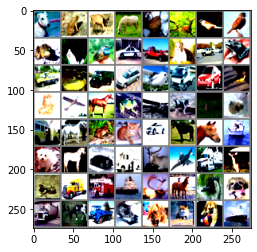

In [32]:
dataiter = iter(dataloader10.test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [33]:
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    dog  frog  deer horse


In [38]:
from tqdm import tqdm

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  pbar = tqdm(dataloader10.test_loader)
  for i, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    outputs = model(data)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == target).squeeze()
    for i in range(4):
        label = target[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
for i in range(10):
  print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

100%|██████████| 157/157 [00:02<00:00, 55.87it/s]

Accuracy of plane : 94 %
Accuracy of   car : 96 %
Accuracy of  bird : 81 %
Accuracy of   cat : 83 %
Accuracy of  deer : 83 %
Accuracy of   dog : 80 %
Accuracy of  frog : 96 %
Accuracy of horse : 94 %
Accuracy of  ship : 94 %
Accuracy of truck : 96 %


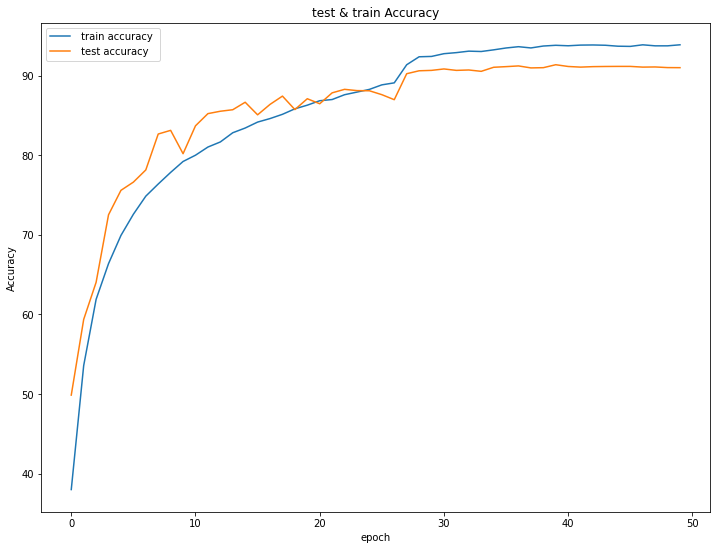

In [39]:
fig, axs = plt.subplots(1,1,figsize=(12,9))
plt.plot(train10.train_acc)
plt.plot(test10.test_acc)

plt.title('test & train Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend([" train accuracy ", ' test accuracy '], loc='best')
plt.show()

In [0]:
target_layers = ["layer1","layer2","layer3","layer4"]
grad_cam = GradCAMView(model ,classes,target_layers )

/content/gdrive/My Drive/Colab Notebooks/EVA/S10/GradCAM/gradcam_visualize.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw={'xticks': [], 'yticks': []})


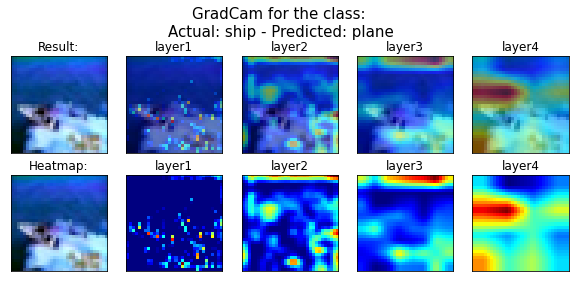

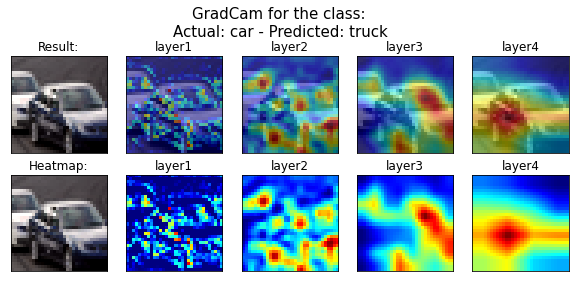

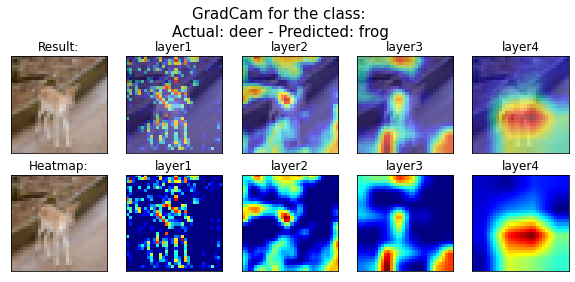

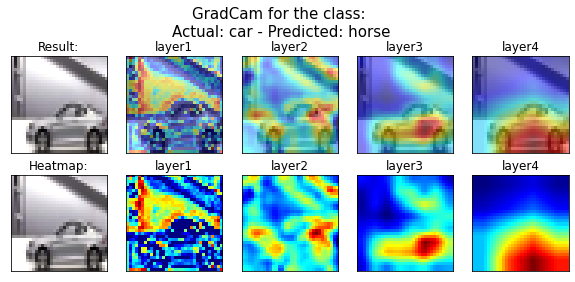

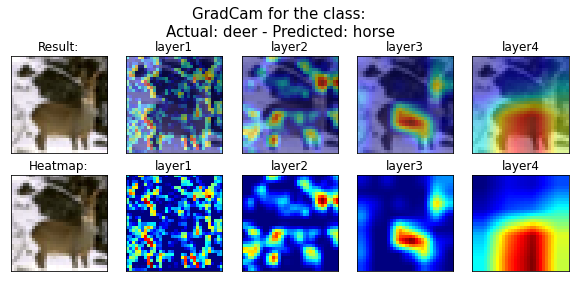

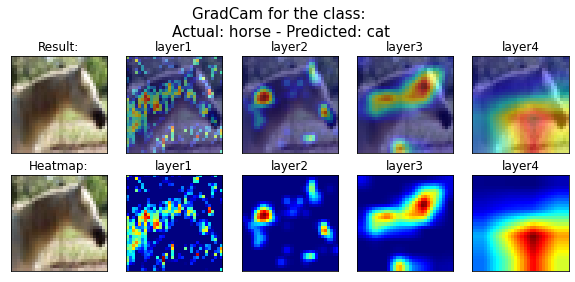

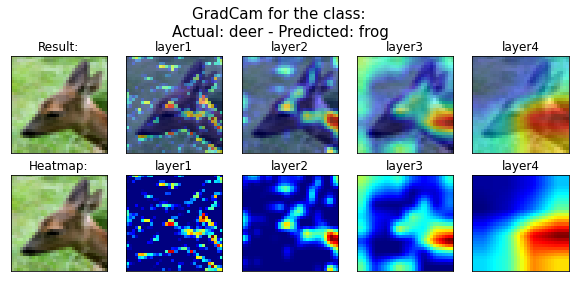

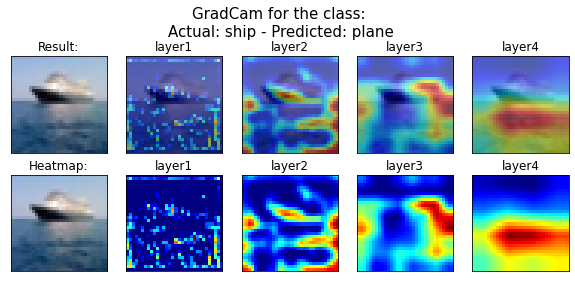

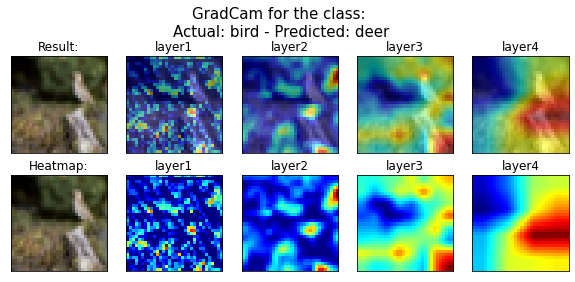

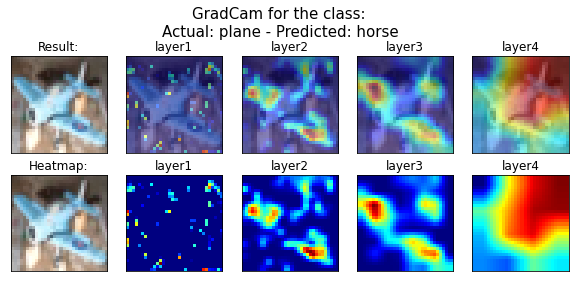

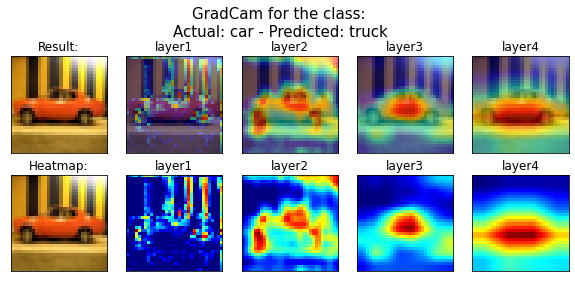

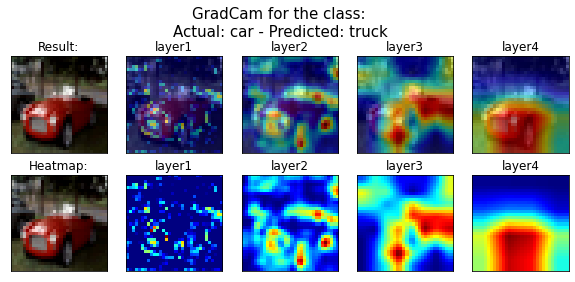

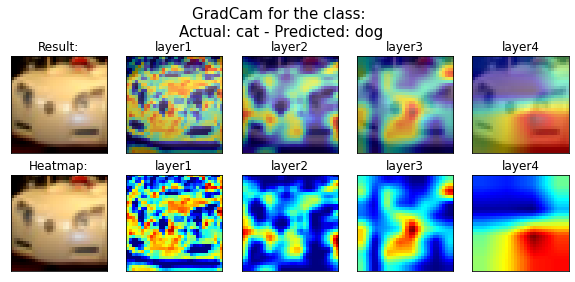

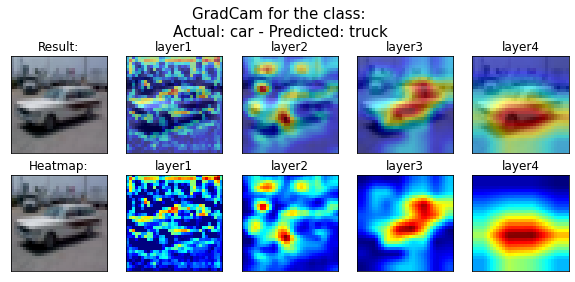

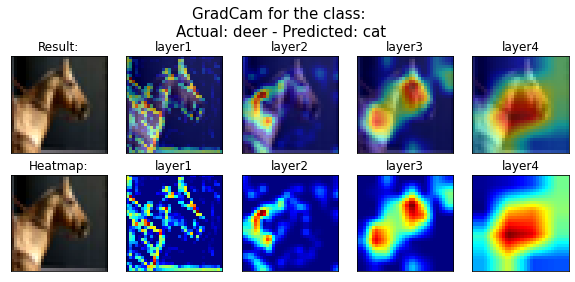

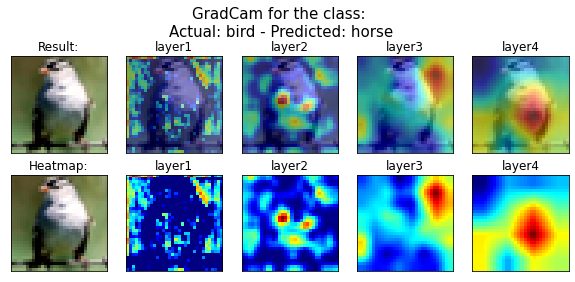

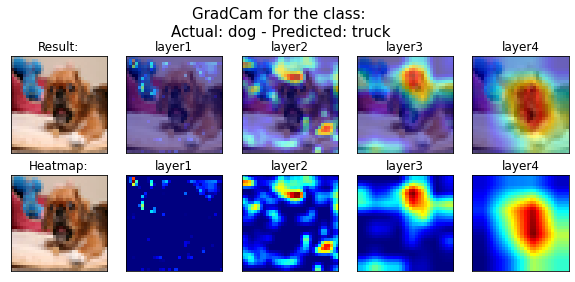

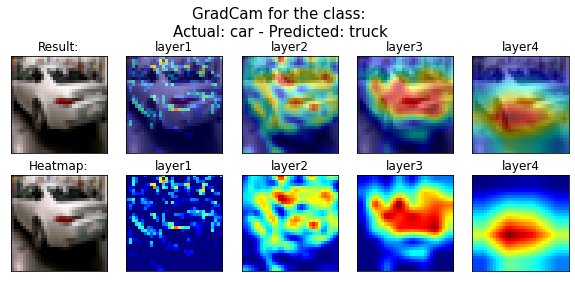

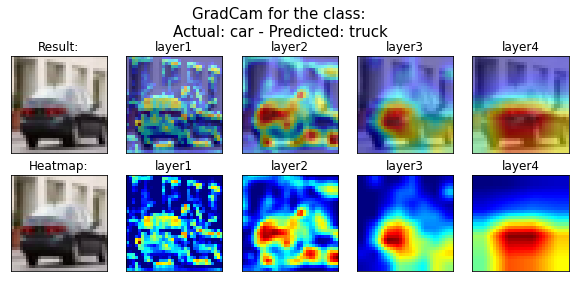

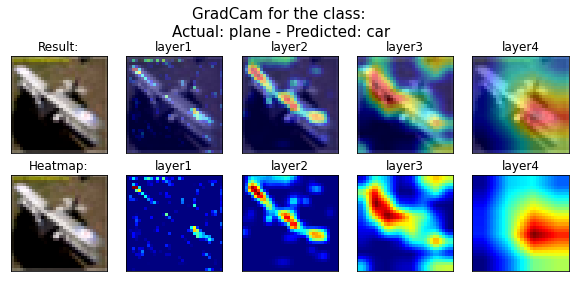

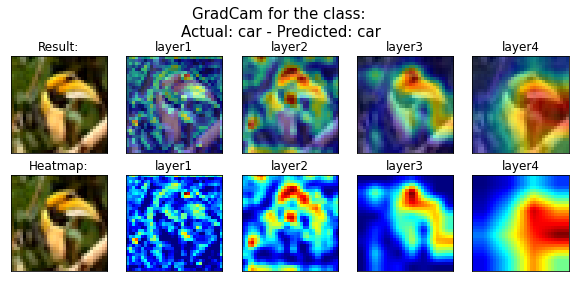

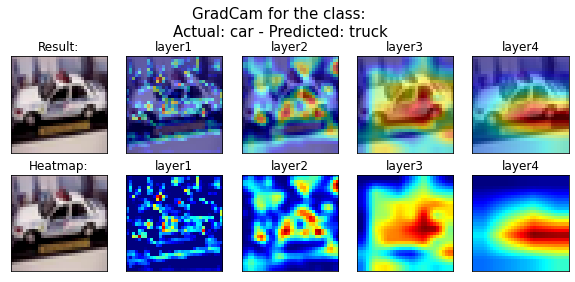

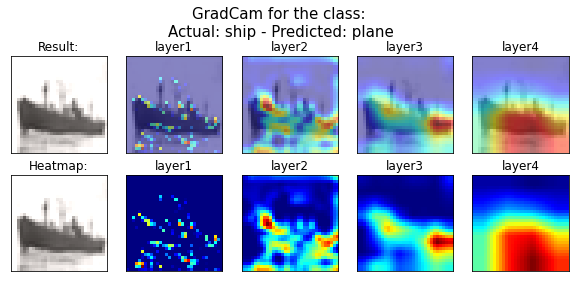

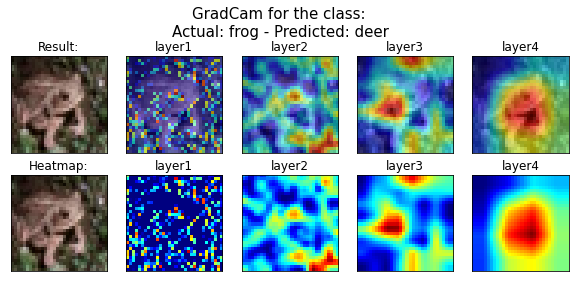

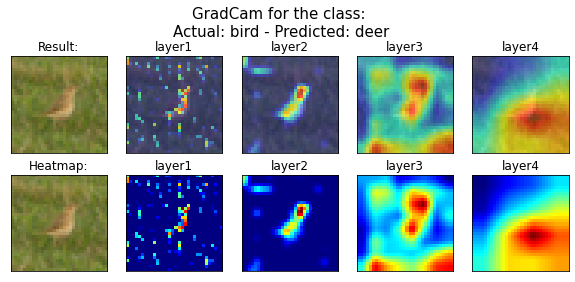

In [43]:
num_img = 25
incorrect_pred_imgs = []
truth_image = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(test10.misclassified[i]["image"]))
  truth_image.append(test10.misclassified[i]["prediction"])
grad_cam(torch.stack(incorrect_pred_imgs), truth_image, target_layers, metric="incorrect",per_image=True)